# Dynamic Connectivity Python Pipeline

Given a subject number, this pipeline seeks to: 

1) Extract fMRI BOLD scan(s) into Atlas

2) Bin ROI Time-series into Predefined Time-Windows

3) Compute Connectomes from each Time-Window

4) Binarize-Threshold the Resulting Matrices

5) Concatenate the Time-Window Matrices into a 3D Array

6) Output 3D Matrices into MATLAB readable format

In [ ]:
indices = []
window_size = 80
window_step = 65
for i in range(0, 673-window_size + 1, window_step):
    indices.append([i, i+window_size])
print(indices)
print(len(indices))

In [1]:
import os
import glob
import nilearn
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
from nilearn import input_data
import nibabel as nib
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import scipy.io
from nilearn import datasets
import sys
import seaborn



In [ ]:
"""FUNCTIONS"""


def extract_fMRI_into_atlas(sub, path, pattern, scan_num, confounds_directory, atlas_dict, output_label, output_directory, cols_to_remove = []):
    # Find all relevant files that match filename "pattern" for subject number "sub". If number of files exceeds "scan_num",
    # select the "scan_num" largest files. Creates a numpy 2D array of shape (number of TRs, number of ROIs)
    directory_path = "%s/sub-%s/func" % (path, sub)
    scan_names = glob.glob(directory_path + "/*Ex*preproc_bold.nii.gz")
    
    if len(scan_names) > scan_num:
        scan_names.sort(key=lambda f: os.stat(f).st_size, reverse=True)
    
    # Check if multiple atlases are provided, if so, extract ROIs and concatenate

    for scan in scan_names:

        # Get corresonding confounds .tsv files for ith scan
        base = "_".join(scan.split("/")[-1].split("_")[:3])
        confounds_filename = confounds_directory + base + '_conformatted.tsv'
        pandas.read_csv(confounds_filename, sep = '\t').fillna(0).to_csv("conf_nona_temp.tsv", sep = '\t', index = False)

        print(scan)
        print("---" + confounds_filename)

        # Load fmri volumes
        func_img = nib.load(scan)
        header_zooms = func_img.header.get_zooms()
        TR = header_zooms[3]
        
        # Initialize Time Series
        time_series = []
        labels = []
        # For each atlas, grab what type of masker to use. Extract ROI timeseries using 
        # appropriate masker object and then concatenate all atlas extractions into one 
        # 2D array Timeseries of shape (number of TRs, total number of ROIs across all atlases)
        for atlas_filename, masker in atlas_dict.items():
            
            # Check which masker to use, then create a masker object and extract scan data into ROI timeseries using masker
            if masker == 'Maps':
                masker = input_data.NiftiMapsMasker(
                    atlas_filename, 
                    resampling_target='data',
                    memory = 'nilearn_cache', 
                    verbose = 0, low_pass=0.1, high_pass=0.01, detrend=True, t_r = TR).fit()
                time_series.append(masker.transform(scan, confounds = 'conf_nona_temp.tsv'))
            elif masker == "Labels":
                masker = NiftiLabelsMasker(
                    labels_img=atlas_filename,
                    standardize=True,
                    memory='nilearn_cache', 
                    verbose=0, low_pass = 0.1, high_pass = 0.01, detrend = True, t_r = TR)
                time_series.append(masker.fit_transform(scan, confounds = 'conf_nona_temp.tsv'))

        # Save timeseries to output directory, using output label and base name for reference
        time_series = np.concatenate(time_series, axis = 1)
        
        if cols_to_remove:
            time_series = np.delete(time_series, obj = cols_to_remove, axis = 1)
            
        np.save("%s/%s_%s_timeseries.npy" % (output_directory, base, output_label), time_series)


def bin_time_series(sub, path, pattern, window_step, window_size):
    # Get scan filenames from subject id and pattern. Initialize empty containers for storing 
    # the resulting binned time windows and the corresponding start-end indices
    scan_filenames = glob.glob(path + "/sub-%s" % sub + pattern)
    scan_time_windows = {}
    indices = []
    
    # For each time series, create a range of start-end indices based on window step and size parameters. 
    # Bin the time series by the indices, and store the resulting sliding time windows into dictionary 
    # where each key is a separate scan and its corresponding item is its 3D array of sliding time windows  
    # of shape (time window, TR number, ROI)
    for ts in scan_filenames:

        time_series = np.load(ts)

        time_windows = []
        for i in range(0, time_series.shape[0]-window_size + 1, window_step):
            window = time_series[i:i + window_size, :]
            time_windows.append(window)
            indices.append([i, i+window_size])

        
        scan_time_windows[ts] = np.asarray(time_windows)
    print(indices)
    return(scan_time_windows)


def connectomes_from_time_windows(time_windows_dict, kind):
    # Initialize a connectivity, of type "kind", as well as a dictionary to store the connectomes
    connectivity = ConnectivityMeasure(kind = kind)
    connectomes_dict = {}
    
    # For each scan's 3D array of time windows, compute their connectomes
    for timeseries_name, time_windows in time_windows_dict.items():
        connectomes_dict[timeseries_name] = connectivity.fit_transform(time_windows)
    
    return(connectomes_dict)


def binarize_threshold(connectomes_dict, threshold):
    # For each 3D Array of Connectomes, go through each Time Window and Binarize it according to 
    # some quantile threshold. Fill diagonal with 0. Return dictionary of 3D Connectome / Scan
    binthresh_connectomes_dict = connectomes_dict.copy()
    
    for timeseries_name, connectomes in binthresh_connectomes_dict.items():
        
        for i in range(connectomes.shape[0]):
            connectome = connectomes[i].copy()
            np.fill_diagonal(connectome, 0)
            abs_thresh = np.quantile(np.abs(connectome), q = threshold)
            connectome[(connectome>=-abs_thresh) & (connectome<=abs_thresh)] = 0
            connectome[connectome != 0] = 1
            connectomes[i] = connectome

        binthresh_connectomes_dict[timeseries_name] = connectomes
        
    return binthresh_connectomes_dict


def save_3D_array(binthresh_connectomes_dict, pattern, output_directory, output_label):
    scipy.io.savemat('%s/%s_%s_3Darray.mat' % (output_directory, pattern, output_label), binthresh_connectomes_dict)
        

In [ ]:
ts = np.load('/mnt/chrastil/lab/users/rob/projects/DynConn/timeseries/sub-033_task-boldEx_run-1_HOsubcort+Schaefer400_2mm_timeseries.npy')
cols_to_remove = [0, 1, 2, 7, 11, 12, 13] 
cols_to_remove = [col + 400 for col in cols_to_remove]
print(cols_to_remove)
ts = np.delete(ts, obj = cols_to_remove, axis = 1)
    
ts.shape

In [3]:
subject = sys.argv[1]
print(subject)

sub = "033"
path = "/mnt/chrastil/lab/data/MLINDIV/preprocessed/derivatives/fmriprep"
confounds_directory = "/mnt/chrastil/lab/users/rob/projects/MachineLearning/confounds/"
timeseries_directory = "/mnt/chrastil/lab/users/rob/projects/DynConn/timeseries"
array_directory = "/mnt/chrastil/lab/users/rob/projects/DynConn/3DArrays"
atlas_filename = '/mnt/chrastil/lab/users/rob/projects/MachineLearning/MLINDIV-DL_251_80_rest.nii.gz'
pattern = "Ex"
scan_num = 2
threshold = 0.9


# HO + Schaeffer Atases
output_label = "HOsubcort+Schaefer400_2mm"
ts_pattern = "*Ex*HOsubcort+Schaefer400_2mm*"

schaefer = datasets.fetch_atlas_schaefer_2018(resolution_mm=2, verbose = 0)
schaefer_atlas = schaefer.maps
schaefer_labels = schaefer.labels
schaefer_masker = "Labels"

ho = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr25-2mm", verbose = 0)
ho_atlas = ho.maps
ho_labels = ho.labels
ho_masker = "Labels"

atlas_dict = {
    schaefer_atlas: schaefer_masker,
    ho_atlas: ho_masker
}


# Code to xecute w/ above parameters
#extract_fMRI_into_atlas(sub, path, pattern, scan_num, confounds_directory, atlas_dict, output_label, timeseries_directory)
#time_windows = bin_time_series(sub, timeseries_directory, ts_pattern, window_step = 15, window_size = 45)
#connectomes = connectomes_from_time_windows(time_windows, kind = 'correlation')
#binthresh_connectomes = binarize_threshold(connectomes, threshold)
#save_3D_array(binthresh_connectomes, pattern, array_directory, output_label)

-f


In [ ]:
binthresh_connectomes['/mnt/chrastil/lab/users/rob/projects/DynConn/timeseries/sub-033_task-boldEx_run-1_HOsubcort+Schaefer400_2mm_timeseries.npy'].shape

In [ ]:
"""
Create an animation walking through binarized thresheld connectomes 
from a specific timeseries
"""
connectomes = binthresh_connectomes['/mnt/chrastil/lab/users/rob/projects/DynConn/timeseries/sub-033_task-boldEx_run-1_HOsubcort+Schaefer400_2mm_timeseries.npy']

fig = plt.figure()
i=0
im = plt.imshow(connectomes[0], animated=True)
def updatefig(i):
    example = connectomes[i].copy()

    """
    np.fill_diagonal(example, 0)
    abs_thresh = np.quantile(np.abs(example), q = .99)

    ex = example.copy()
    ex[(ex>=-abs_thresh) & (ex<=abs_thresh)] = 0
    ex[ex != 0] =1
    """

    im.set_array(example)
    
    return im,
ani = animation.FuncAnimation(fig, updatefig, frames = range(42),  blit=True, interval = 15*720/10)


HTML(ani.to_html5_video())

In [4]:
ho_labels

['Background',
 'Left Cerebral White Matter',
 'Left Cerebral Cortex ',
 'Left Lateral Ventrical',
 'Left Thalamus',
 'Left Caudate',
 'Left Putamen',
 'Left Pallidum',
 'Brain-Stem',
 'Left Hippocampus',
 'Left Amygdala',
 'Left Accumbens',
 'Right Cerebral White Matter',
 'Right Cerebral Cortex ',
 'Right Lateral Ventricle',
 'Right Thalamus',
 'Right Caudate',
 'Right Putamen',
 'Right Pallidum',
 'Right Hippocampus',
 'Right Amygdala',
 'Right Accumbens']

# Post-MATLAB Analysis

In [5]:
# Load in Betweenness centrality output from Matlab, add proper labels and subject IDs,
# Format subject IDs
subset_ho_labels = ho_labels.copy()
subset_ho_labels = subset_ho_labels[1:]

cols_to_remove = [0, 1, 2, 7, 11, 12, 13]
rois_to_remove = [subset_ho_labels[idx] for idx in cols_to_remove]

print("-----REMOVING ROIS-----", end = "\n   ")
for roi in rois_to_remove:
    print(roi, end = '\n   ')
    subset_ho_labels.remove(roi)

bc_labels = []
s_l = list(schaefer_labels)
s_l = [str(label).strip('b').strip("'") for label in s_l]
bc_labels.extend(s_l)
bc_labels.extend(list(subset_ho_labels))


bc = pandas.read_csv("/mnt/chrastil/lab/users/rob/projects/DynConn/subcort_COH_betweenessCentrality.csv", names = bc_labels)
bc_subs = pandas.read_table("/mnt/chrastil/lab/users/rob/projects/DynConn/subcort_coh_bc_log.txt", skiprows = 9)
bc_subs = list(bc_subs['Subject Labels:'])
bc.insert(0, 'Subject', bc_subs)
bc['Subject'] = bc['Subject'].apply(lambda x: '{:03d}'.format(int(x)))


-----REMOVING ROIS-----
   Left Cerebral White Matter
   Left Cerebral Cortex 
   Left Lateral Ventrical
   Brain-Stem
   Right Cerebral White Matter
   Right Cerebral Cortex 
   Right Lateral Ventricle
   

In [17]:
import pickle
with open("bc_labels.txt", "wb") as fp: 
    pickle.dump(bc_labels, fp)

In [6]:
vis_network = [col for col in bc.columns if 'Vis' in col]
sommot_network = [col for col in bc.columns if 'SomMot' in col]
dorsatt_network = [col for col in bc.columns if 'DorsAtt' in col]
salventattn_network = [col for col in bc.columns if 'SalVentAttn' in col]
limbic_network = [col for col in bc.columns if 'Limbic' in col]
cont_network = [col for col in bc.columns if 'Cont' in col]
default_network = [col for col in bc.columns if 'Default' in col]

Vis, SomMot, DorsAtt, SalVentAttn, Limbic, Cont, Default = [], [], [], [], [] ,[], []

for index, row in bc.iterrows():
    Vis.append(bc[vis_network].iloc[index].mean())
    SomMot.append(bc[sommot_network].iloc[index].mean())
    DorsAtt.append(bc[dorsatt_network].iloc[index].mean())
    SalVentAttn.append(bc[salventattn_network].iloc[index].mean())
    Limbic.append(bc[limbic_network].iloc[index].mean())
    Cont.append(bc[cont_network].iloc[index].mean())
    Default.append(bc[default_network].iloc[index].mean())
    
bet_centr = bc.copy()

# Put networks at end of bc matrix, then look at corrs
bet_centr.insert(415, "Vis", Vis)
bet_centr.insert(416, "SomMot", SomMot)
bet_centr.insert(417, "DorsAtt", DorsAtt)
bet_centr.insert(418, "SalVentAttn", SalVentAttn)
bet_centr.insert(419, "Limbic", Limbic)
bet_centr.insert(420, "Cont", Cont)
bet_centr.insert(421, "Default", Default)
bet_centr

,Subject,7Networks_LH_Vis_1,7Networks_LH_Vis_2,7Networks_LH_Vis_3,7Networks_LH_Vis_4,7Networks_LH_Vis_5,7Networks_LH_Vis_6,7Networks_LH_Vis_7,7Networks_LH_Vis_8,7Networks_LH_Vis_9,...,Right Hippocampus,Right Amygdala,Right Accumbens,Vis,SomMot,DorsAtt,SalVentAttn,Limbic,Cont,Default
0,002,49.522630,46.341135,63.705816,72.041734,58.698245,46.574309,62.143642,77.460827,65.269716,...,40.523273,64.255340,20.389103,59.205330,54.224152,65.293972,55.684180,49.345365,62.962815,69.864387
1,003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,005,48.898038,59.255695,50.637142,63.798285,61.055400,70.580622,26.623802,75.970171,49.543357,...,47.783283,47.292361,36.691902,59.897127,51.605459,57.281310,57.349280,48.398420,58.190841,58.805593
3,014,54.938741,51.301581,73.529385,90.659444,48.392404,69.235534,37.699315,99.749700,73.752162,...,50.952977,54.103796,33.116515,66.064874,64.840024,81.072605,65.618630,55.707152,68.144625,78.093504
4,015,57.029049,45.253473,46.037987,56.228506,54.321889,56.360188,60.430769,82.379585,36.021950,...,50.451829,44.931688,63.217513,56.272392,47.562421,65.439772,56.360705,46.096531,57.150291,64.407171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,109,60.799047,66.752355,51.752799,55.156636,29.293505,71.105114,44.034217,98.000114,61.985327,...,86.588209,42.579335,31.283254,54.600943,66.117748,70.305670,73.949428,44.459153,64.693159,63.833055
84,110,57.105692,60.699511,59.416005,86.632398,67.937272,58.921279,39.734513,108.645855,33.646772,...,40.786760,41.835326,37.985047,63.666590,54.891768,72.326492,66.413753,40.978088,64.170321,73.382899
85,111,65.657015,45.328484,74.368380,45.166266,60.706979,64.967072,55.079712,75.989027,49.923996,...,36.285202,54.979685,36.964660,58.502735,47.394997,63.753109,57.100408,48.387054,58.175300,66.767417
86,112,56.894586,43.209353,42.950838,66.041817,57.808759,55.998093,32.409028,47.105837,58.174070,...,44.769651,61.945650,23.380473,58.073929,59.894911,77.745089,66.758693,43.256220,69.310742,66.522503


In [9]:

part_data = pandas.read_csv("/mnt/chrastil/lab/data/MLINDIV/preprocessed/behavioral/MLINDIV_participant_master.csv")
part_data = part_data.loc[part_data['Subject'].isin(bet_centr.Subject)]
bet_centr.insert(1, 'tm_accuracy', list(part_data.tm_accuracy))
bet_centr.insert(1, 'tm_path_efficiencies', list(part_data.tm_path_efficiencies))
bet_centr.insert(1, 'tm_average_RT', list(part_data.tm_average_RT))
bet_centr = bet_centr.dropna()
networks = ["Vis", "SomMot", "DorsAtt", "SalVentAttn" , "Limbic", "Cont", "Default"]

Left Pallidum
R: 0.248	p-value: 0.021546
Left Hippocampus
R: -0.222	p-value: 0.040378
Right Caudate
R: -0.184	p-value: 0.089529
Right Hippocampus
R: -0.292	p-value: 0.006385


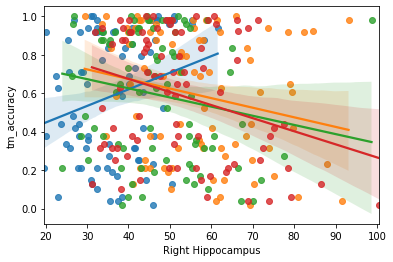

In [21]:


for region in bet_centr.columns[-21:]:
    r, p = scipy.stats.pearsonr(bet_centr[region], bet_centr['tm_accuracy'])
    if p < 0.1:
        print(region)
        print("R: %.3f\tp-value: %f" % (r, p))
        seaborn.regplot(x = region, y = 'tm_accuracy', data = bet_centr)


Cont
R: 0.181	p-value: 0.096002


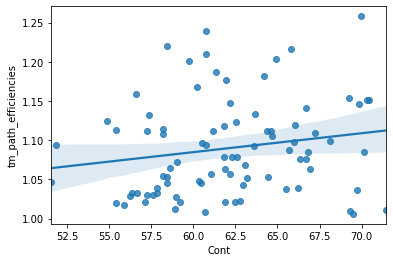

In [22]:


for region in bet_centr.columns[-21:]:
    r, p = scipy.stats.pearsonr(bet_centr[region], bet_centr['tm_path_efficiencies'])
    if p < .1:
        print(region)
        print("R: %.3f\tp-value: %f" % (r, p))
        seaborn.regplot(x = region, y = 'tm_path_efficiencies', data = bet_centr)

    
    

In [ ]:
left_acc = seaborn.regplot(x = "Left Accumbens", y = 'tm_path_efficiencies', data = bet_centr)
left_acc.set(ylabel = "Mean Trial Path Efficiency")


In [ ]:
right_put = seaborn.regplot(x = "Right Putamen", y = 'tm_path_efficiencies', data = bet_centr)
right_put.set(ylabel = "Mean Trial Path Efficiency")

In [ ]:
right_cau = seaborn.regplot(x = "Right Caudate", y = 'tm_path_efficiencies', data = bet_centr)
right_cau.set(ylabel = "Mean Trial Path Efficiency")

In [ ]:
bc.shape

Left Caudate
R: 0.202	p-value: 0.061666
Left Pallidum
R: -0.201	p-value: 0.063462
Left Accumbens
R: -0.187	p-value: 0.084360
Right Pallidum
R: -0.287	p-value: 0.007460
Right Hippocampus
R: 0.247	p-value: 0.021987


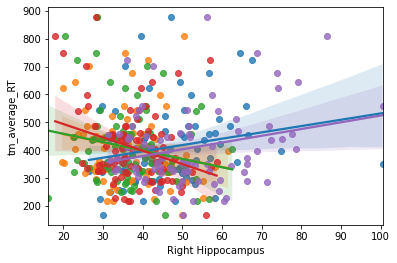

In [23]:
for region in bet_centr.columns[-21:]:
    r, p = scipy.stats.pearsonr(bet_centr[region], bet_centr['tm_average_RT'])
    if p < 0.1:
        seaborn.regplot(x = region, y = 'tm_average_RT', data = bet_centr)
   
        print(region)
        print("R: %.3f\tp-value: %f" % (r, p))